In [1]:
import math

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
# Earth radius in kilometers
Earth_Radius_KM = 6371

# ref : https://en.wikipedia.org/wiki/Haversine_formula
def haversine_distance(origin: tuple[float, float], destination: tuple[float, float]) -> float:
    '''
        Calculates the haversine distance between two geographic coordinates in kilometers.

        The haversine formula is used to calculate the great-circle distance between two points on a sphere given their geographic coordinates (latitude and longitude). This function takes two tuples of latitude and longitude in degrees, converts them to radians, and returns the distance in kilometers using the Earth's radius.

        Args:
            origin (tuple): A tuple of (latitude, longitude) in degrees for the first location.
            destination (tuple): A tuple of (latitude, longitude) in degrees for the second location.

        Returns:
            float: The distance between the two locations in kilometers.
    '''
    # convert to radians
    origin_lat_rad, origin_lon_rad = map(math.radians, origin)
    dest_lat_rad, dest_lon_rad = map(math.radians, destination)
    
    # differences in coordinates
    diff_in_lat = origin_lat_rad - dest_lat_rad
    diff_in_lon = origin_lon_rad - dest_lon_rad
    
    # haversine formula
    haversine_value = math.sin(diff_in_lat / 2)**2 + math.cos(origin_lat_rad) * math.cos(dest_lat_rad) * math.sin(diff_in_lon / 2)**2
    great_circle_angle = 2 * math.atan2(math.sqrt(haversine_value), math.sqrt(1 - haversine_value))
    
    # return distance in kilometers
    return Earth_Radius_KM * great_circle_angle

In [3]:
# geneate random datasets with distance, ranking index [0, 1000], ranking score [0, 100], and recall score [0, 1]
origin_location = (13.730535078167222, 100.51722744907757)
random_locations = [(13.741460172760418, 100.52945703900683), (13.722747225901431, 100.49704947551552), (13.751713487254452, 100.51226159917519), (13.743477711408703, 100.4995739810327), (13.714646756745294, 100.54927435500979), (13.693737924271923, 100.49201727752865), (13.619711506655612, 100.53902398019436), (13.912907423320988, 100.6063458466953), (13.914512135214704, 100.60634242176562), (13.522935037016458, 100.66803031320607)]

# calculate the distance between the origin and each random location
distance = [haversine_distance(origin_location, location) for location in random_locations]

# ranking index proportional to distance (scaled to [0, 1000])
def calculate_ranking_index(distances):
    # scale distances to [0, 1000]
    return np.clip((distances / 100) * 1000, 0, 1000).astype(int)
# apply the function to each row's distance list
ranking_index = [calculate_ranking_index(d) for d in distance]

# ranking score proportional to ranking index (scaled to [0, 100])
def calculate_inverse_ranking_score(index):
    # inverse proportionality: higher index -> lower score
    epsilon = 1e-5
    score = 1000 / (index + epsilon) 
    # hormalize to 0 to 100 scale
    normalized_score = np.clip(score, 0, 100)
    return normalized_score
ranking_score = np.array([calculate_inverse_ranking_score(index) for index in ranking_index])

# recall score [0, 1]
recall_score = np.random.uniform(0, 1, size=len(random_locations))

df =  pd.DataFrame({
    "Distance": distance,
    "Ranking Index": ranking_index,
    "Ranking Score": ranking_score,
    "Recall Score": recall_score
})
df

,Distance,Ranking Index,Ranking Score,Recall Score
0,1.794646,17,58.823495,0.569889
1,2.345333,23,43.478242,0.301743
2,2.415243,24,41.666649,0.530036
3,2.388966,23,43.478242,0.880211
4,3.886496,38,26.315783,0.606804
5,4.915107,49,20.408159,0.461061
6,12.546020,125,7.999999,0.589970
7,22.446085,224,4.464286,0.449956
8,22.607251,226,4.424779,0.283707
9,28.256856,282,3.546099,0.758248


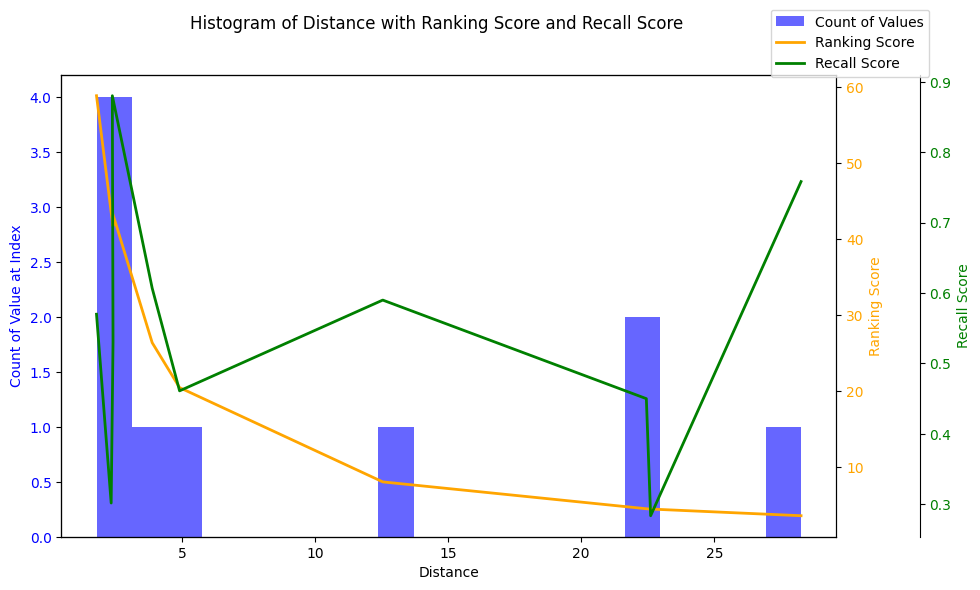

In [4]:
import matplotlib.pyplot as plt

# plot data
fig, ax1 = plt.subplots(figsize=(10, 6))

# plot histogram (count of values) on the left y-axis
ax1.hist(df["Distance"], bins=20, alpha=0.6, color="blue", label="Count of Values")
ax1.set_xlabel("Distance")
ax1.set_ylabel("Count of Value at Index", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

# add second y-axis for Ranking Score as a line graph
ax2 = ax1.twinx()
ax2.plot(df["Distance"], df["Ranking Score"], color="orange", label="Ranking Score", linewidth=2)
ax2.set_ylabel("Ranking Score", color="orange")
ax2.tick_params(axis="y", labelcolor="orange")

# add third y-axis for Recall Score as a line graph
ax3 = ax1.twinx()  # Create another twin axis
ax3.spines["right"].set_position(("outward", 60))  # Offset the third axis to avoid overlap
ax3.plot(df["Distance"], df["Recall Score"], color="green", label="Recall Score", linewidth=2)
ax3.set_ylabel("Recall Score", color="green")
ax3.tick_params(axis="y", labelcolor="green")

# add a title and show the plot
fig.suptitle("Histogram of Distance with Ranking Score and Recall Score")
fig.legend(loc="upper right", bbox_to_anchor=(1, 1))
plt.show()